In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import MCM


C:\Users\86130\AppData\Local\Temp\ipykernel_28656\3334840638.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [9]:
def calculate_weight(data):
    RI = (0, 0, 0.52, 0.89, 1.12, 1.26, 1.36, 1.41, 1.46, 1.49, 1.52, 1.54, 1.56, 1.58, 1.59)
    # 转化为array类型的对象
    in_matrix = np.array(data)
    n, n2 = in_matrix.shape
    # 判断矩阵是否为方阵，而且矩阵的大小为n，n2
    if n != n2:
        print("不是一个方阵，所以不能进行接下来的步骤")
        return None
    for i in range(0, n):
        for j in range(0, n2):
            if np.abs(in_matrix[i, j] * in_matrix[j, i] - 1) > 1e-7:
                raise ValueError("不为正互反矩阵")
    eig_values, eig_vectors = np.linalg.eig(in_matrix)
    # eigvalues为特征向量，eigvectors为特征值构成的对角矩阵（而且其他位置都为0，对角元素为特征值）
    max_index = np.argmax(eig_values)
    # argmax为获取最大特征值的下标,而且这里是获取实部
    max_eig = eig_values[max_index].real
    # 这里max_eig是最大的特征值
    eig_ = eig_vectors[:, max_index].real
    eig_ = eig_ / eig_.sum()
    if n > 15:
        CR = None
        warnings.warn(("无法判断一致性"))
    else:
        CI = (max_eig - n) / (n - 1)
        if RI[n - 1] != 0:
            CR = CI / RI[n - 1]
        if CR < 0.1:
            print("矩阵的一致性可以被接受")
        else:
            print("矩阵的一致性不能被接受")
    return max_eig, CR, CI, eig_
'''
1	1/4	1/6	1/2	2	1
4	1	1/3	1	5	4
6	3	1	3	7	7
2	1	1/3	1	3	4
1/2	1/5	1/7	1/3	1	1/2
1	1/4	1/7	1/4	2	1
'''
data = [[1, 1/4, 1/6, 1/2, 2, 1],
        [4, 1, 1/3, 1, 5, 4],
        [6, 3, 1, 3, 7, 7],
        [2, 1, 1/3, 1, 3, 4],
        [1/2, 1/5, 1/7, 1/3, 1, 1/2],
        [1, 1/4, 1/7, 1/4, 2, 1]]
max_eig,CR,CI,weight_AHP = calculate_weight(data)
print(max_eig,CR,CI,weight_AHP)

矩阵的一致性可以被接受
6.146013326065803 0.023176718423143294 0.02920266521316055 [0.07025152 0.20749535 0.44614435 0.17022297 0.04428676 0.06159905]


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import MCM

origin_data = pd.read_csv('./Wimbledon_featured_matches.csv')
origin_data['p1_get_point'] = (origin_data['point_victor'] == 1).astype(int)
origin_data['p2_get_point'] = (origin_data['point_victor'] == 2).astype(int)
origin_data['k1_1'] = -(origin_data['serve_no']-1) * (origin_data['server'] == 1).astype(int)
origin_data['k1_2'] = -(origin_data['serve_no']-1) * (origin_data['server'] == 2).astype(int)
origin_data['k2_1'] = origin_data['p1_get_point'] - origin_data['p1_ace']
origin_data['k2_2'] = origin_data['p2_get_point'] - origin_data['p2_ace']
origin_data['k3_1'] = origin_data['p1_ace']
origin_data['k3_2'] = origin_data['p2_ace']
origin_data['k4_1'] = -origin_data['p1_double_fault']
origin_data['k4_2'] = -origin_data['p2_double_fault']
origin_data['k5_1'] = -(origin_data['p1_unf_err'] - origin_data['p1_double_fault'])
origin_data['k5_2'] = -(origin_data['p2_unf_err'] - origin_data['p2_double_fault'])
origin_data['k6_1'] = origin_data['rally_count'] * (1 - 2 * origin_data['p1_get_point']) * (1 - origin_data['p2_double_fault'])
origin_data['k6_2'] = origin_data['rally_count'] * (1 - 2 * origin_data['p2_get_point']) * (1 - origin_data['p1_double_fault'])

In [29]:
def entropy_weight(data):
    p = data / data.sum(axis=0)
    E = (-p * np.log(p)).sum(axis=0) * (1 / np.log(data.shape[0]))
    D = 1 - E
    W = D / D.sum()
    return W
#所有指标归一化至[0,1]
metrics = ['k1_1', 'k1_2', 'k2_1', 'k2_2', 'k3_1', 'k3_2', 'k4_1', 'k4_2', 'k5_1', 'k5_2', 'k6_1', 'k6_2']
metric_1 = ['k1_1','k2_1','k3_1','k4_1','k5_1','k6_1']
metric_2 = ['k1_2','k2_2','k3_2','k4_2','k5_2','k6_2']
origin_data[metrics] = (origin_data[metrics] - origin_data[metrics].min()) / (origin_data[metrics].max() - origin_data[metrics].min()) * 0.99 + 0.01
#使用熵权法计算每一个指标的权重
weight_entropy = entropy_weight(np.concatenate((origin_data[metric_1].values, origin_data[metric_2].values),axis=0))
weight = np.sqrt(weight_AHP * weight_entropy)
print(weight)


[0.06449126 0.21811498 0.54535181 0.02994185 0.03993918 0.01492001]


In [40]:
origin_data['p1_m'] = origin_data[metric_1].values.dot(weight.T)
origin_data['p2_m'] = origin_data[metric_2].values.dot(weight.T)
p1_m_avg = np.zeros(len(origin_data))
p2_m_avg = np.zeros(len(origin_data))
match_begin = 0
match_end = 0
for i in range(1, len(origin_data)):
    if origin_data['match_id'][i] != origin_data['match_id'][i-1] or i == len(origin_data) - 1:
        match_end = i
        temp_data_server = origin_data[match_begin:match_end]['server'].to_numpy()
        temp_data_p1_m = origin_data[match_begin:match_end]['p1_m'].to_numpy()
        temp_data_p2_m = origin_data[match_begin:match_end]['p2_m'].to_numpy()
        p1_server_avg = temp_data_p1_m[temp_data_server == 1].mean()
        p1_notserver_avg = temp_data_p1_m[temp_data_server == 2].mean()
        p2_server_avg = temp_data_p2_m[temp_data_server == 2].mean()
        p2_notserver_avg = temp_data_p2_m[temp_data_server == 1].mean()
        p1_m_avg[match_begin:match_end][temp_data_server == 1] = p1_server_avg
        p1_m_avg[match_begin:match_end][temp_data_server == 2] = p1_notserver_avg
        p2_m_avg[match_begin:match_end][temp_data_server == 2] = p2_server_avg
        p2_m_avg[match_begin:match_end][temp_data_server == 1] = p2_notserver_avg
        match_begin = i
origin_data['p1_m_avg'] = origin_data['p1_m'] / p1_m_avg
origin_data['p2_m_avg'] = origin_data['p2_m'] / p2_m_avg

In [42]:
#MCM.save({'max_eig':max_eig,'CR':CR,'CI':CI,'weight_AHP':weight_AHP,'weight_entropy':weight_entropy,'weight':weight,'p1_m_avg':origin_data['p1_m_avg'],'p2_m_avg':origin_data['p2_m_avg']},'weight')

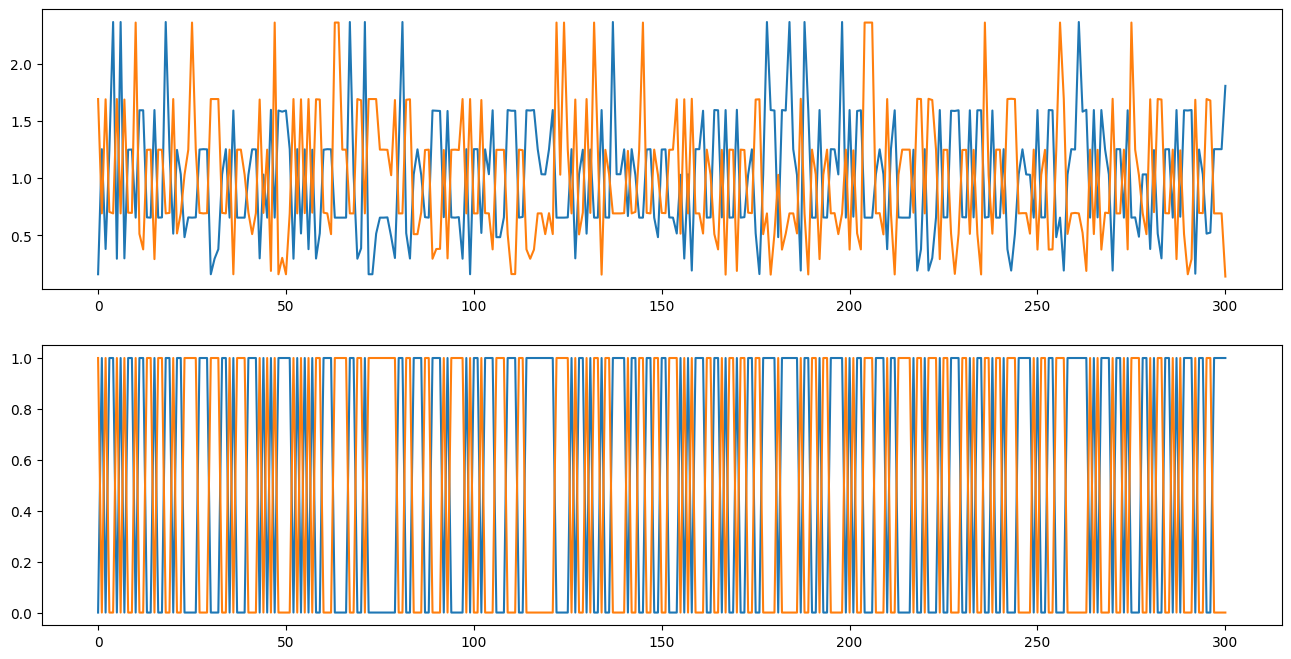

In [46]:
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.plot(origin_data['p1_m_avg'][0:301],label='p1_m_avg')
plt.plot(origin_data['p2_m_avg'][0:301],label='p2_m_avg')
plt.subplot(2,1,2)
plt.plot(origin_data['p1_get_point'][0:301],label='p1_get_point')
plt.plot(origin_data['p2_get_point'][0:301],label='p2_get_point')
plt.show()